In [ ]:
# Data Source
# 1. CIFAR-10: https://www.cs.toronto.edu/~kriz/cifar.html Accessed on 2024 11 11
#   - Files: data_batch_1, data_batch_2, data_batch_3, data_batch_4, data_batch_5, test_batch
#   - Renamed to: cifar10-train-1, cifar10-train-2, cifar10-train-3, cifar10-train-4, cifar10-train-5, cifar10-test

# 2. Fashion-MNIST: https://github.com/zresearch/fashion-mnist Accessed on 2024 11 11
#   - Files: train-images-idx3-ubyte, train-labels-idx1-ubyte, t10k-images-idx3-ubyte, t10k-labels-idx1-ubyte
#   - Renamed to: fmnist-train-image, fmnist-train-label, fmnist-test-image, fmnist-test-label

In [1]:
# Importing Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import setuptools.dist  # To avoid tensorflow import error for distutils, requires setuptools to be installed
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-11-14 16:25:22.351819: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 16:25:22.536236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731572722.601638   21129 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731572722.622333   21129 cuda_blas.cc:1418] Unable to register cuBL

CIFAR-10
Train Data | Label : (50000, 3072)  |  (50000,)
Test Data | Label : (10000, 3072)  |  (10000,)
Fashion MNIST
Train Data | Label : (60000, 784)  |  (60000,)
Test Data | Label : (10000, 784)  |  (10000,)
CIFAR-10


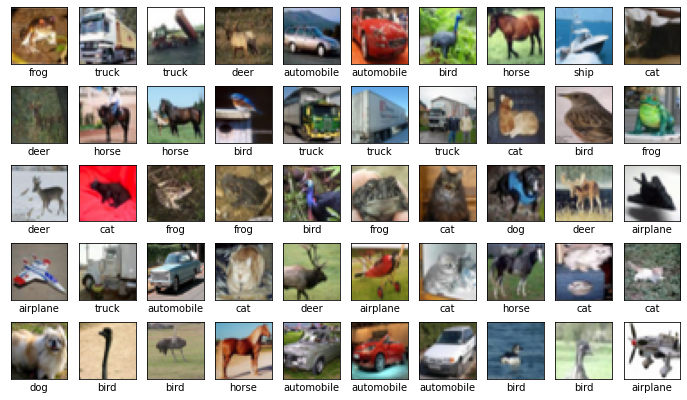

Fashion MNIST


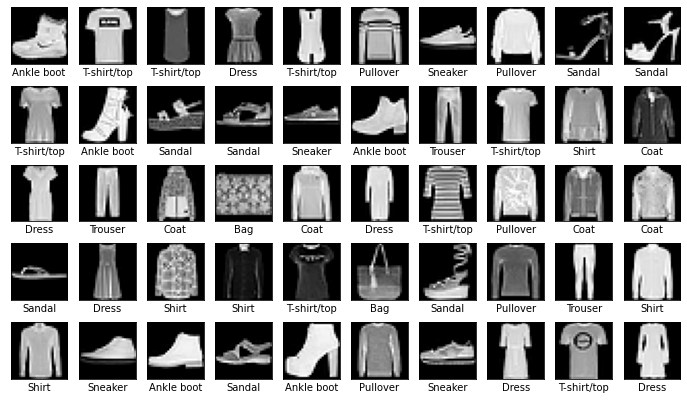

In [3]:
# ==================================================================================================== Step 1. Loading Data
# 1. CIFAR-10 Ref: https://www.cs.toronto.edu/~kriz/cifar.html
# CIFAR-10 Class Label
cifar10_classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]


# For loading pickle files. From https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    import pickle

    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict


# Data Frame for CIFAR-10
cifar10_train_data = []
cifar10_train_label = []

cifar10_test_data = []
cifar10_test_label = []


# 1.1 Load Train Data
for i in range(1, 6):
    file = f"./data/cifar10-train-{i}"
    cifar10_test_file = unpickle(file)
    cifar10_train_data.append(cifar10_test_file[b"data"])
    cifar10_train_label.append(cifar10_test_file[b"labels"])

cifar10_train_data = np.concatenate(cifar10_train_data)
cifar10_train_label = np.concatenate(cifar10_train_label)


# 1.2 Load Test Data
cifar10_test_file = unpickle("./data/cifar10-test")
cifar10_test_data.append(cifar10_test_file[b"data"])
cifar10_test_label.append(cifar10_test_file[b"labels"])
cifar10_test_data = np.concatenate(cifar10_test_data)
cifar10_test_label = np.concatenate(cifar10_test_label)


# 2. Fashion-MNIST Ref: https://pjreddie.com/projects/mnist-in-csv/ , https://www.kaggle.com/code/pavansanagapati/a-simple-cnn-model-beginner-guide
# Fashion MNIST Class Label
fmnist_classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]


# For converting idx to csv
def idx2csv(image_file, label_file, output_file):
    with open(image_file, "rb") as f:
        image_data = f.read()

    with open(label_file, "rb") as f:
        label_data = f.read()

    # Skip header
    image_data = image_data[16:]
    label_data = label_data[8:]
    image_length = len(image_data) // 784  # 28x28 = 784
    label_length = len(label_data)  # 1 byte per label
    images = np.zeros((image_length, 784), dtype=np.uint8)  # 28x28 = 784
    labels = np.zeros((label_length), dtype=np.uint8)  # 1 byte per label

    # i = image index, j = pixel index
    for i in range(image_length):
        for j in range(784):
            images[i, j] = image_data[i * 784 + j]  # 28x28 = 784

    # i = label index
    for i in range(label_length):
        labels[i] = label_data[i]  # 1 byte per label

    # Save to csv
    np.savetxt(
        output_file,
        np.concatenate((labels.reshape(-1, 1), images), axis=1),
        delimiter=",",
        fmt="%d",
    )


# 2.1 Convert idx to csv
if not os.path.exists("./data/fmnist-train.csv"):
    idx2csv("./data/fmnist-train-image", "./data/fmnist-train-label", "./data/fmnist-train.csv")
if not os.path.exists("./data/fmnist-test.csv"):
    idx2csv("./data/fmnist-test-image", "./data/fmnist-test-label", "./data/fmnist-test.csv")

# 2.2 Load Data
fmnist_train_data = pd.read_csv("./data/fmnist-train.csv", header=None).loc[:, 1:].values
fmnist_train_label = pd.read_csv("./data/fmnist-train.csv", header=None).loc[:, 0].values
fmnist_test_data = pd.read_csv("./data/fmnist-test.csv", header=None).loc[:, 1:].values
fmnist_test_label = pd.read_csv("./data/fmnist-test.csv", header=None).loc[:, 0].values


# 3. Display Data
# 3.1 Display Data Shape
print("CIFAR-10")
print("Train Data | Label :", cifar10_train_data.shape, " | ", cifar10_train_label.shape)
print("Test Data | Label :", cifar10_test_data.shape, " | ", cifar10_test_label.shape)
print("Fashion MNIST")
print("Train Data | Label :", fmnist_train_data.shape, " | ", fmnist_train_label.shape)
print("Test Data | Label :", fmnist_test_data.shape, " | ", fmnist_test_label.shape)

# 3.2 Display image with label and class
# CIFAR-10
print("CIFAR-10")
plt.figure(figsize=(12, 7))
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cifar10_train_data[i].reshape(3, 32, 32).transpose(1, 2, 0))
    plt.xlabel(cifar10_classes[cifar10_train_label[i]])
plt.show()

# Fashion MNIST
print("Fashion MNIST")
plt.figure(figsize=(12, 7))
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fmnist_train_data[i].reshape(28, 28), cmap="gray")
    plt.xlabel(fmnist_classes[fmnist_train_label[i]])
plt.show()

In [4]:
# ==================================================================================================== Step 2. Data Preprocessing
# 1. CIFAR-10
# 1.1 Normalization
cifar10_train_data_normed = cifar10_train_data / 255.0
cifar10_test_data_normed = cifar10_test_data / 255.0

# 1.2 Reshape
cifar10_train_data_normed = cifar10_train_data_normed.reshape(-1, 32, 32, 3)  # 3 for RGB
cifar10_test_data_normed = cifar10_test_data_normed.reshape(-1, 32, 32, 3)  # 3 for RGB

# 2. Fashion-MNIST
# 2.1 Normalization
fmnist_train_data_normed = fmnist_train_data / 255.0
fmnist_test_data_normed = fmnist_test_data / 255.0

# 2.2 Reshape
fmnist_train_data_normed = fmnist_train_data_normed.reshape(-1, 28, 28, 1)  # 1 for grayscale
fmnist_test_data_normed = fmnist_test_data_normed.reshape(-1, 28, 28, 1)  # 1 for grayscale


# 3. Check data shape before and after normalization
print("CIFAR-10 - Train Original Shape:", cifar10_train_data.shape, " | Normalized Shape:", cifar10_train_data_normed.shape)
print("CIFAR-10 - Test Original Shape:", cifar10_test_data.shape, " | Normalized Shape:", cifar10_test_data_normed.shape)
print("Fashion MNIST - Train Original Shape:", fmnist_train_data.shape, " | Normalized Shape:", fmnist_train_data_normed.shape)
print("Fashion MNIST - Test Original Shape:", fmnist_test_data.shape, " | Normalized Shape:", fmnist_test_data_normed.shape)

# 4. Verify content of data
print("CIFAR-10 - Train Data")
print(cifar10_train_data[1])
print("CIFAR-10 - Train Data Normalized")
print(cifar10_train_data_normed[1])
print("Fashion MNIST - Train Data")
print(fmnist_train_data[1])
print("Fashion MNIST - Train Data Normalized")
print(fmnist_train_data_normed[1])

CIFAR-10 - Train Original Shape: (50000, 3072)  | Normalized Shape: (50000, 32, 32, 3)
CIFAR-10 - Test Original Shape: (10000, 3072)  | Normalized Shape: (10000, 32, 32, 3)
Fashion MNIST - Train Original Shape: (60000, 784)  | Normalized Shape: (60000, 28, 28, 1)
Fashion MNIST - Test Original Shape: (10000, 784)  | Normalized Shape: (10000, 28, 28, 1)
CIFAR-10 - Train Data
[154 126 105 ... 139 142 144]
CIFAR-10 - Train Data Normalized
[[[0.60392157 0.49411765 0.41176471]
  [0.4        0.49019608 0.60784314]
  [0.6745098  0.70588235 0.55686275]
  ...
  [0.34509804 0.40392157 0.36862745]
  [0.25490196 0.3254902  0.35294118]
  [0.30980392 0.26666667 0.2627451 ]]

 [[0.53333333 0.5372549  0.47843137]
  [0.51764706 0.59215686 0.70980392]
  [0.79607843 0.81568627 0.81568627]
  ...
  [0.36078431 0.34509804 0.30588235]
  [0.34117647 0.38431373 0.29803922]
  [0.2627451  0.31764706 0.35686275]]

 [[0.57254902 0.48627451 0.34509804]
  [0.33333333 0.34117647 0.32941176]
  [0.29411765 0.30588235 0.

In [ ]:
# Model architecture
# 1. Basic architecture
# Input Layer > Conv2D > MaxPooling2D > Conv2D > MaxPooling2D > Flatten > Dense > Output Layer

# 2. Model architecture from Kaggle
# CIFAR-10: https://www.kaggle.com/code/roblexnana/cifar10-with-cnn-for-beginer
# Model: Conv2D > Conv2D > MaxPooling2D > Dropout > Conv2D > Conv2D > MaxPooling2D > Dropout > Flatten > Dense > Dropout > Dense

# CIFAR-10: https://www.kaggle.com/code/ektasharma/simple-cifar10-cnn-keras-code-with-88-accuracy/notebook
# Model: Conv2D > BatchNorm > Conv2D > BatchNorm > MaxPooling2D > Dropout > Conv2D > BatchNorm > Conv2D > BatchNorm > MaxPooling2D > Dropout > Conv2D > BatchNorm > Conv2D > BatchNorm > MaxPooling2D > Dropout > Flatten > Dense > BatchNorm > Dropout > Dense

# Fashion MNIST: https://www.kaggle.com/code/pavansanagapati/a-simple-cnn-model-beginner-guide
# Model: Conv2D > MaxPooling2D > Dropout > Flatten > Dense > Dense

# Fashion MNIST: https://www.kaggle.com/code/franklemuchahary/basic-cnn-keras-with-cross-validation
# Model: Conv2D > conv2D > MaxPooling2D > Flatten > Dense > Dropout > Dense > Dense

# 3. Proposed Model - basic (single model for both CIFAR and Fashion MNIST)
# Model: Conv2D > MaxPooling2D > Conv2D > MaxPooling2D > Flatten > Dense > Dense

# 4. Proposed Model - advanced (single model (with underfitting and overfitting handling + k-fold cross validation) for both CIFAR and Fashion MNIST)
# Model: Conv2D > BatchNorm > Conv2D > BatchNorm > MaxPooling2D > Dropout > Conv2D > BatchNorm > Conv2D > BatchNorm > MaxPooling2D > Dropout > Conv2D > BatchNorm > Conv2D > BatchNorm > MaxPooling2D > Dropout > Flatten > Dense > BatchNorm > Dropout > Dense

# Method for addressing Underfitting and Overfitting
# 1. General: Learning rate, epochs
# 2. Underfitting: Data augmentation (rotation, flip, zoom, shift)
# 3. Overfitting handling: Dropout, l2 regularization, BatchNormalization

In [8]:
# ==================================================================================================== Step 3. Model Building
# 1. Model Building
# 1.1 Basic Model
def build_basic_model(input_shape, num_classes):
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu", input_shape=input_shape),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation="relu"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )
    return model


# 1.2 Advanced Model
def build_advanced_model(input_shape, num_classes):
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu", input_shape=input_shape),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )
    return model


# 2. Model Compilation
# 2.1 Basic Model
basic_model_cifar = build_basic_model((32, 32, 3), 10)
basic_model_cifar.compile(optimizer="adam", loss="SparseCategoricalCrossentropy", metrics=["accuracy"])
basic_model_fmnist = build_basic_model((28, 28, 1), 10)
basic_model_fmnist.compile(optimizer="adam", loss="SparseCategoricalCrossentropy", metrics=["accuracy"])

# 2.2 Advanced Model
advanced_model_cifar = build_advanced_model((32, 32, 3), 10)
advanced_model_cifar.compile(optimizer="adam", loss="SparseCategoricalCrossentropy", metrics=["accuracy"])
advanced_model_fmnist = build_advanced_model((28, 28, 1), 10)
advanced_model_fmnist.compile(optimizer="adam", loss="SparseCategoricalCrossentropy", metrics=["accuracy"])

# 2.3 Model Summary
print("Basic Model - CIFAR")
basic_model_cifar.summary()
print("Basic Model - Fashion MNIST")
basic_model_fmnist.summary()
print("Advanced Model - CIFAR")
advanced_model_cifar.summary()
print("Advanced Model - Fashion MNIST")
advanced_model_fmnist.summary()

Basic Model - CIFAR


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

Basic Model - Fashion MNIST


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

Advanced Model - CIFAR


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 552,874 (2.11 MB)

 Trainable params: 551,722 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

Advanced Model - Fashion MNIST


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 437,610 (1.67 MB)

 Trainable params: 436,458 (1.66 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [9]:
# ==================================================================================================== Step 4. Model Training
# 1. Set early stopping and checkpoint
n_folds = 5
epochs = 10
batch_size = 64
model_history_cifar10_basic = []
model_history_cifar10_advance = []
model_history_fmnist_basic = []
model_history_fmnist_advance = []

pat = 5  # Number of epochs with no improvement after which training will be stopped
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

# Set checkpoint
cifar10_basic_checkpoint_path = "./model/cifar10_basic_model.keras"
cifar10_advance_checkpoint_path = "./model/cifar10_advance_model.keras"
cifar10_basic_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=cifar10_basic_checkpoint_path, save_best_only=True, verbose=1)
cifar10_advance_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=cifar10_advance_checkpoint_path, save_best_only=True, verbose=1)
fmnist_basic_checkpoint_path = "./model/fmnist_basic_model.keras"
fmnist_advance_checkpoint_path = "./model/fmnist_advance_model.keras"
fmnist_basic_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=fmnist_basic_checkpoint_path, save_best_only=True, verbose=1)
fmnist_advance_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=fmnist_advance_checkpoint_path, save_best_only=True, verbose=1)


# Define fit function
def fit_and_evaluate(model, model_checkpoint, train_data, train_label, test_data, test_label, epochs, batch_size):
    history = model.fit(train_data, train_label, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, model_checkpoint], verbose=1, validation_split=0.1)
    print("Validation Accuracy: ", model.evaluate(test_data, test_label))
    return history


# 2. Model Training
# 1.1 Basic Model
# CIFAR-10
model_history_cifar10_basic.append(fit_and_evaluate(basic_model_cifar, cifar10_basic_cp_callback, cifar10_train_data_normed, cifar10_train_label, cifar10_test_data_normed, cifar10_test_label, epochs, batch_size))
model_history_fmnist_basic.append(fit_and_evaluate(basic_model_fmnist, fmnist_basic_cp_callback, fmnist_train_data_normed, fmnist_train_label, fmnist_test_data_normed, fmnist_test_label, epochs, batch_size))

# 1.2 Advanced Model with K-Fold Cross Validation
# CIFAR-10
for i in range(n_folds):
    print("Training CIFAR-10 on Fold: ", i + 1)
    t_x, val_x, t_y, val_y = train_test_split(cifar10_train_data_normed, cifar10_train_label, test_size=0.1, random_state=np.random.randint(1, 1000, 1)[0])
    model_history_cifar10_advance.append(fit_and_evaluate(advanced_model_cifar, cifar10_advance_cp_callback, t_x, t_y, val_x, val_y, epochs, batch_size))
    print("END ==========================================================================")

# Fashion MNIST
for i in range(n_folds):
    print("Training Fashion MNIST on Fold: ", i + 1)
    t_x, val_x, t_y, val_y = train_test_split(fmnist_train_data_normed, fmnist_train_label, test_size=0.1, random_state=np.random.randint(1, 1000, 1)[0])
    model_history_fmnist_advance.append(fit_and_evaluate(advanced_model_fmnist, fmnist_advance_cp_callback, t_x, t_y, val_x, val_y, epochs, batch_size))
    print("END ==========================================================================")

Epoch 1/10


I0000 00:00:1731573256.753036   21570 service.cc:148] XLA service 0x7f580000baa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731573256.753464   21570 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti Laptop GPU, Compute Capability 8.6
2024-11-14 16:34:16.784559: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731573256.898568   21570 cuda_dnn.cc:529] Loaded cuDNN version 90300


 57/704 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1647 - loss: 2.2618

I0000 00:00:1731573259.169445   21570 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3520 - loss: 1.8035
Epoch 1: val_loss improved from inf to 1.44912, saving model to ./model/cifar10_basic_model.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.3521 - loss: 1.8031 - val_accuracy: 0.4906 - val_loss: 1.4491
Epoch 2/10
699/704 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5425 - loss: 1.3063
Epoch 2: val_loss improved from 1.44912 to 1.21166, saving model to ./model/cifar10_basic_model.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5427 - loss: 1.3060 - val_accuracy: 0.5734 - val_loss: 1.2117
Epoch 3/10
698/704 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5964 - loss: 1.1457
Epoch 3: val_loss improved from 1.21166 to 1.10859, saving model to ./model/cifar10_basic_model.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5964 - loss: 1.1456 - val_accuracy: 0.6166 - val_loss: 1.1086
Epoch 4/10
702/704 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6344 - loss: 1.0461
Epoch 4: val_l

2024-11-14 16:34:44.327264: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_66', 4 bytes spill stores, 4 bytes spill loads



313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6493 - loss: 1.0956
Validation Accuracy:  [1.1114659309387207, 0.6496000289916992]
Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7750 - loss: 0.6262
Epoch 1: val_loss improved from inf to 0.30744, saving model to ./model/fmnist_basic_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7751 - loss: 0.6259 - val_accuracy: 0.8903 - val_loss: 0.3074
Epoch 2/10
843/844 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8913 - loss: 0.3053
Epoch 2: val_loss did not improve from 0.30744
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8913 - loss: 0.3053 - val_accuracy: 0.8830 - val_loss: 0.3175
Epoch 3/10
828/844 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9092 - loss: 0.2529
Epoch 3: val_loss improved from 0.30744 to 0.26596, saving model to ./model/fmnist_basic_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9092 - loss: 0.2528 - val_accuracy: 0.9008 - val_loss: 0.2660
Epoch 4/

2024-11-14 16:35:31.516392: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4290', 4 bytes spill stores, 4 bytes spill loads



633/633 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2390 - loss: 2.4269
Epoch 1: val_loss improved from inf to 1.71341, saving model to ./model/cifar10_advance_model.keras
633/633 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.2391 - loss: 2.4263 - val_accuracy: 0.3836 - val_loss: 1.7134
Epoch 2/10
629/633 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4188 - loss: 1.6106
Epoch 2: val_loss improved from 1.71341 to 1.49107, saving model to ./model/cifar10_advance_model.keras
633/633 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4190 - loss: 1.6102 - val_accuracy: 0.4691 - val_loss: 1.4911
Epoch 3/10
626/633 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4829 - loss: 1.4321
Epoch 3: val_loss improved from 1.49107 to 1.34954, saving model to ./model/cifar10_advance_model.keras
633/633 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4830 - loss: 1.4318 - val_accuracy: 0.5142 - val_loss: 1.3495
Epoch 4/10
632/633 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5251 - loss: 1.3270
Epoch

In [ ]:
# ==================================================================================================== Step 5. Model Evaluation
# 1. Model Evaluation
# 1.1 Basic Model
color = ["black", "red", "green", "blue", "orange"]
# CIFAR-10
plt.title("Basic Model - CIFAR-10 - Train Accuracy vs Val Accuracy")
plt.plot(model_history_cifar10_basic[0].history['accuracy'], label='train', color=color[0])
plt.plot(model_history_cifar10_basic[0].history['val_accuracy'], label='val', color=color[1])
plt.legend()
plt.show()
# Fashion MNIST
plt.title("Basic Model - Fashion MNIST - Train Accuracy vs Val Accuracy")
plt.plot(model_history_fmnist_basic[0].history['accuracy'], label='train', color=color[0])
plt.plot(model_history_fmnist_basic[0].history['val_accuracy'], label='val', color=color[1])
plt.legend()
plt.show()

# 1.2 Advanced Model
# CIFAR-10
plt.title("Advanced Model - CIFAR-10 - Train Accuracy vs Val Accuracy")
for i in range(n_folds):
    plt.plot(model_history_cifar10_advance[i].history['accuracy'], label='train fold ' + str(i + 1), color=color[i])
    plt.plot(model_history_cifar10_advance[i].history['val_accuracy'], label='val fold ' + str(i + 1), color=color[i], linestyle="dashed")
plt.legend()
plt.show()
# Fashion MNIST
plt.title("Advanced Model - Fashion MNIST - Train Accuracy vs Val Accuracy")
for i in range(n_folds):
    plt.plot(model_history_fmnist_advance[i].history['accuracy'], label='train fold ' + str(i + 1), color=color[i])
    plt.plot(model_history_fmnist_advance[i].history['val_accuracy'], label='val fold ' + str(i + 1), color=color[i], linestyle="dashed")
plt.legend()
plt.show()

In [ ]:
# ==================================================================================================== Step 6. Model Prediction
# 1. Model Prediction
# 1.1 Basic Model
cifar10_test_prediction_basic = basic_model_cifar.predict(cifar10_test_data_normed)
fmnist_test_prediction_basic = basic_model_fmnist.predict(fmnist_test_data_normed)

# 1.2 Advanced Model
cifar10_test_prediction_advanced = advanced_model_cifar.predict(cifar10_test_data_normed)
fmnist_test_prediction_advanced = advanced_model_fmnist.predict(fmnist_test_data_normed)

# 2. Display Prediction
# 2.1 Basic Model
# CIFAR-10
plt.figure(figsize=(20, 7))
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cifar10_test_data[i].reshape(3, 32, 32).transpose(1, 2, 0))
    plt.xlabel(f"{cifar10_classes[cifar10_test_label[i]]} - {cifar10_classes[np.argmax(cifar10_test_prediction_basic[i])]}")
plt.show()

# Fashion MNIST
plt.figure(figsize=(20, 7))
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fmnist_test_data[i].reshape(28, 28), cmap="gray")
    plt.xlabel(f"{fmnist_classes[fmnist_test_label[i]]} - {fmnist_classes[np.argmax(fmnist_test_prediction_basic[i])]}")
plt.show()

# 2.2 Advanced Model
# CIFAR-10
plt.figure(figsize=(20, 7))
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cifar10_test_data[i].reshape(3, 32, 32).transpose(1, 2, 0))
    plt.xlabel(f"{cifar10_classes[cifar10_test_label[i]]} - {cifar10_classes[np.argmax(cifar10_test_prediction_advanced[i])]}")
plt.show()

# Fashion MNIST
plt.figure(figsize=(20, 7))
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fmnist_test_data[i].reshape(28, 28), cmap="gray")
    plt.xlabel(f"{fmnist_classes[fmnist_test_label[i]]} - {fmnist_classes[np.argmax(fmnist_test_prediction_advanced[i])]}")
plt.show()